In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

In [2]:
#!pip install -e .

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Read data

In [4]:
metadata = pd.read_csv('../data/plasticc/plasticc_train_metadata.csv.gz')
data = pd.read_csv('../data/plasticc/plasticc_train_lightcurves.csv.gz')

data = data[data.detected_bool == 1]

In [5]:
object_ids = np.unique(data.object_id)

In [6]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

In [7]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [8]:
def is_good(anobject):
    good = 1
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        good = 0
    
    # keep only objects with at least 10 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 10:
            count += 1
    if count > 3:
        good = 0
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        good = 0
    
    return good

# Visual analysis

In [9]:
def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

24947


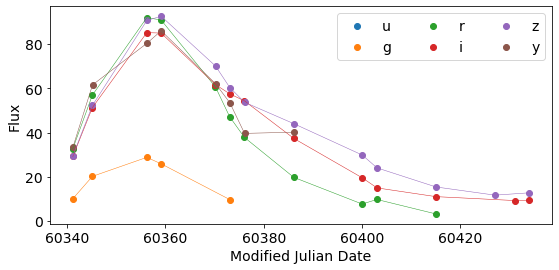

34299


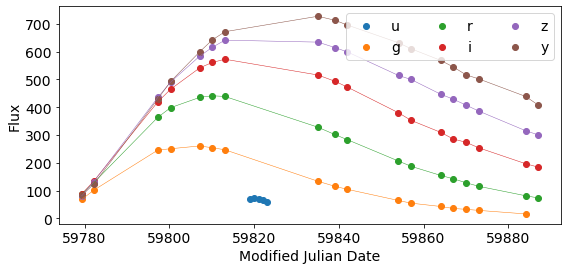

42469


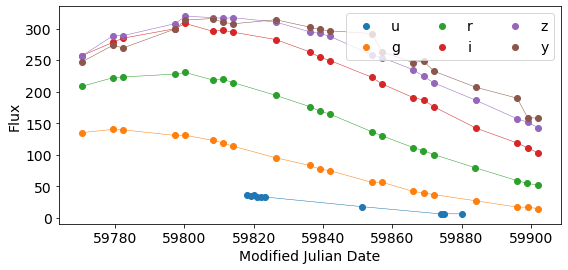

66852


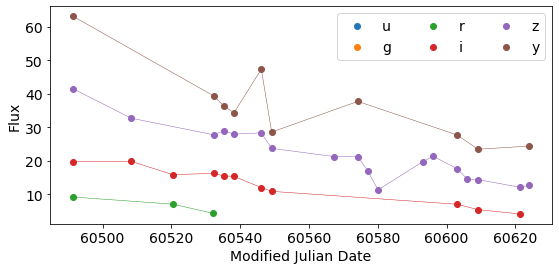

70046


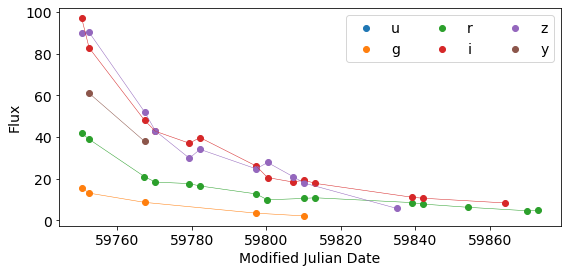

84716


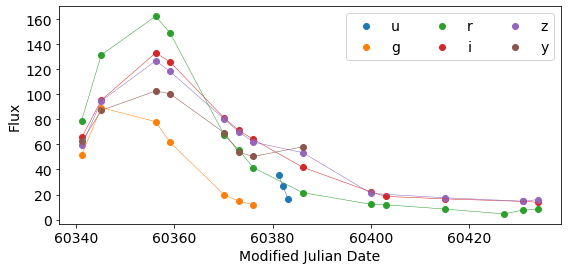

99013


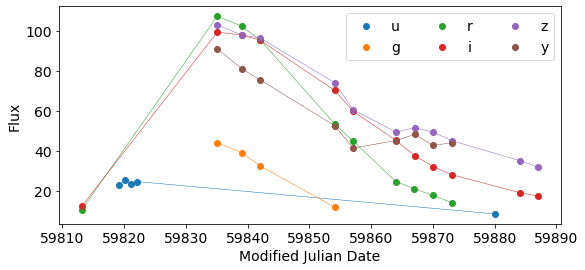

125242


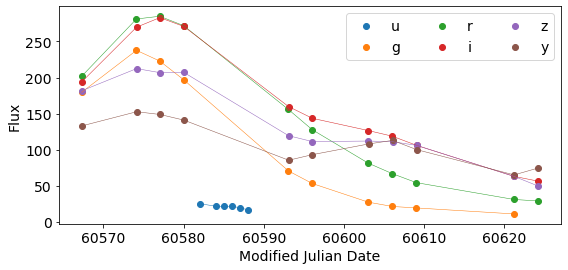

131629


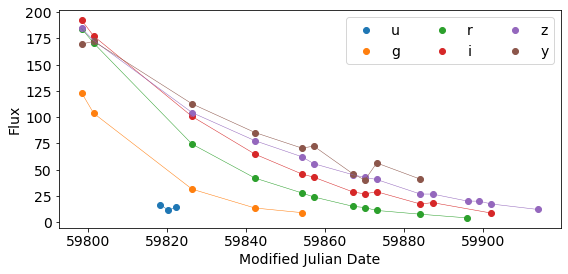

136110


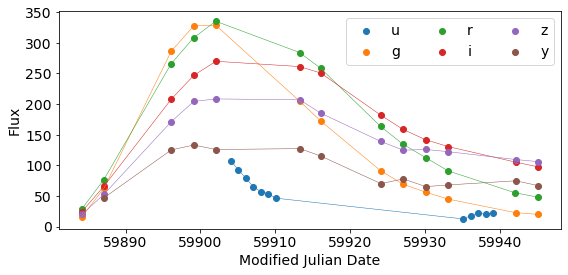

149129


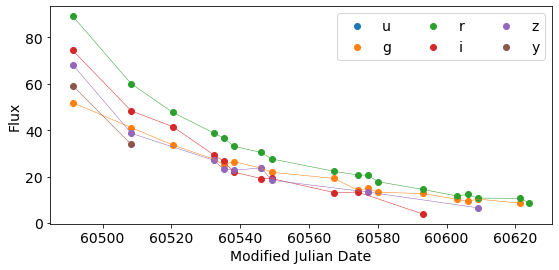

166727


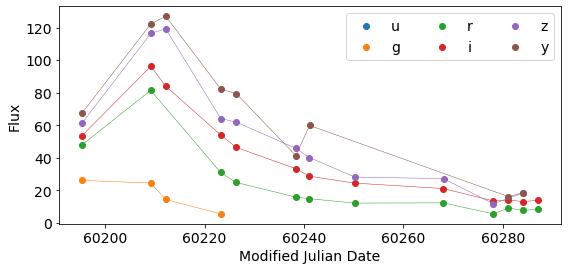

169315


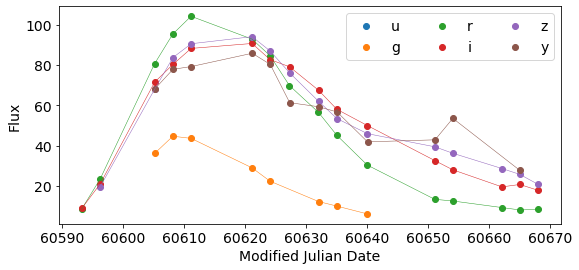

207535


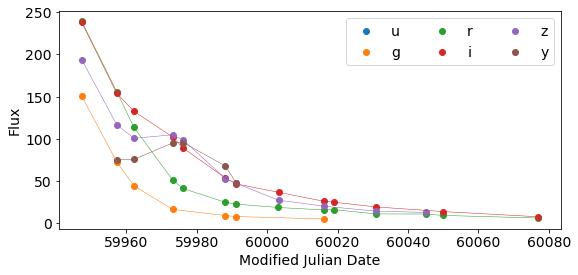

229855


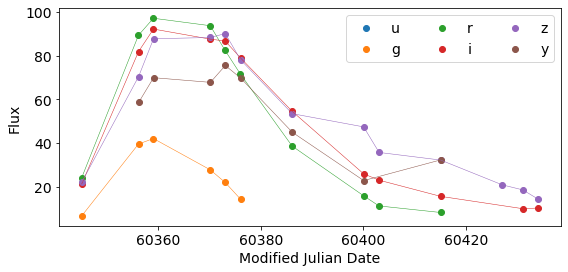

249956


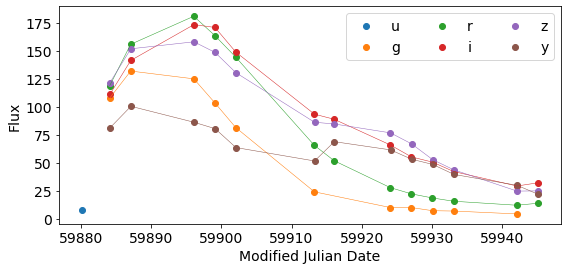

252646


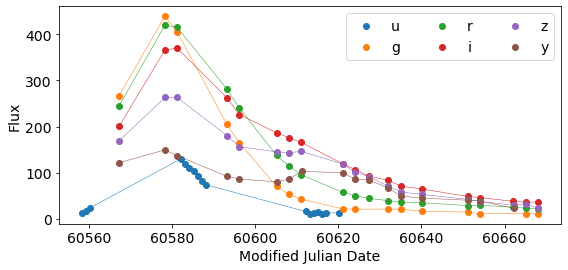

281110


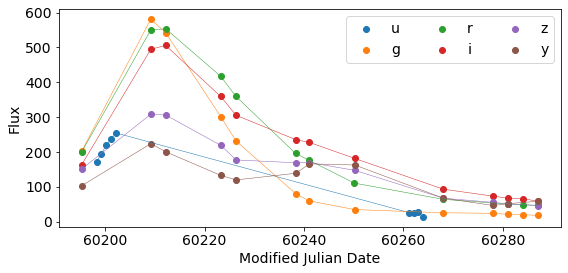

290682


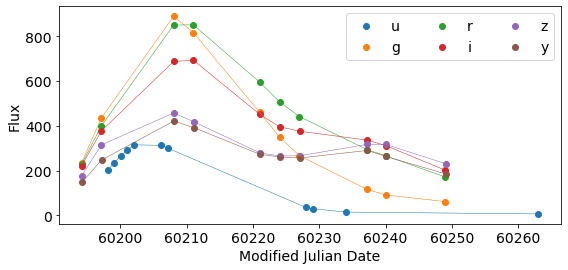

294647


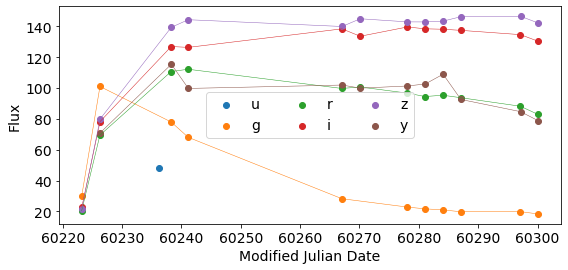

299348


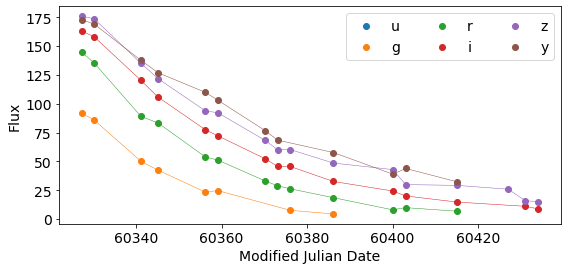

314352


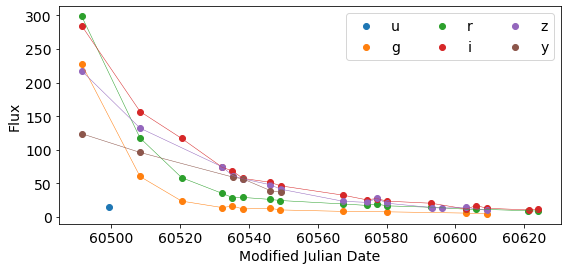

329277


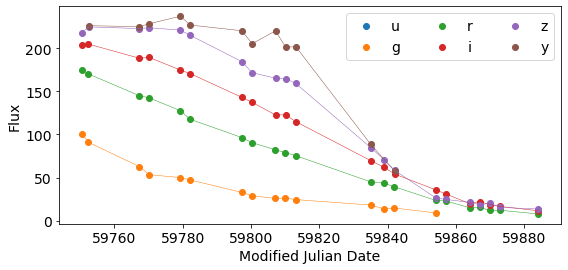

In [10]:
for i in object_ids[::20]:
    anobject = get_object(data, i)
    
    if not is_good(anobject): continue
    print(i)
    
    plot_light_curves(anobject)
    plt.show()

# Example

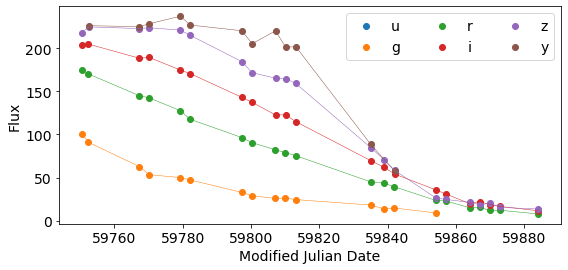

In [11]:
anobject = get_object(data, 329277)

plot_light_curves(anobject)

# Train and test split

In [12]:
from binned_split import binned_train_test_split

In [13]:
t = anobject['mjd'].values

anobject_train, anobject_test = binned_train_test_split(anobject, 
                                                        t=t, 
                                                        bin_size=20, 
                                                        test_size=1, 
                                                        shuffle=True, 
                                                        random_state=42, 
                                                        bounds_in_train=True)

# Data Preparation

In [14]:
t_train = anobject_train['mjd'].values
flux_train = anobject_train['flux'].values
flux_err_train = anobject_train['flux_err'].values
passband_train = anobject_train['passband'].values

t_test = anobject_test['mjd'].values
flux_test = anobject_test['flux'].values
flux_err_test = anobject_test['flux_err'].values
passband_test = anobject_test['passband'].values

In [15]:
def plot_light_curves_with_sigma(t, flux, flux_err, passband, title=""):
    colors = ['C'+str(i) for i in range(len(np.unique(passband)))]
    plt.figure(figsize=(9, 4))
    for i, pb in enumerate(np.unique(passband)):
        plt.plot(t[passband == pb], flux[passband == pb], linewidth=2., color=colors[i])
        plt.fill_between(t[passband == pb], 
                         flux[passband == pb]+1*flux_err[passband == pb], 
                         flux[passband == pb]-1*flux_err[passband == pb], label=passband2name[pb], alpha=0.5, color=colors[i])
    plt.xlabel('Time', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

# Augmentation

In [16]:
import fulu

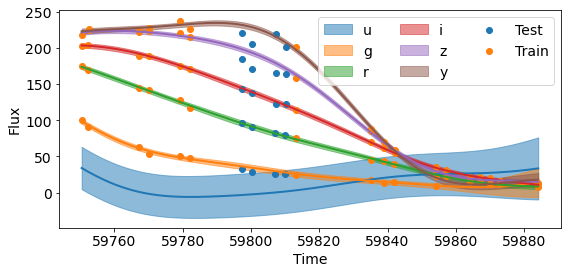

In [17]:
aug = fulu.GaussianProcessesAugmentation(passband2lam)

aug.fit(t_train, flux_train, flux_err_train, passband_train)
t_aug, flux_aug, flux_err_aug, passband_aug= aug.augmentation(t_min=t.min(), t_max=t.max(), n_obs=1000)

plot_light_curves_with_sigma(t_aug, flux_aug, flux_err_aug, passband_aug, title="")
plt.scatter(t_test, flux_test, label='Test')
plt.scatter(t_train, flux_train, label='Train')
plt.legend(loc='best', ncol=3, fontsize=14)

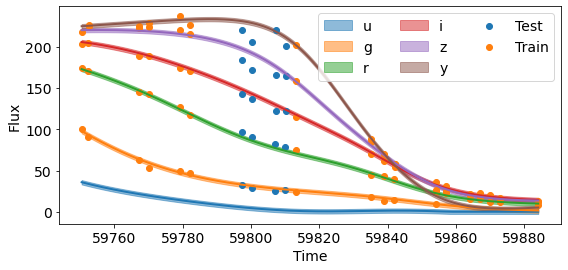

In [18]:
aug = fulu.MLPRegressionAugmentation(passband2lam)

aug.fit(t_train, flux_train, flux_err_train, passband_train)
t_aug, flux_aug, flux_err_aug, passband_aug= aug.augmentation(t_min=t.min(), t_max=t.max(), n_obs=1000)

plot_light_curves_with_sigma(t_aug, flux_aug, flux_err_aug, passband_aug, title="")
plt.scatter(t_test, flux_test, label='Test')
plt.scatter(t_train, flux_train, label='Train')
plt.legend(loc='best', ncol=3, fontsize=14)

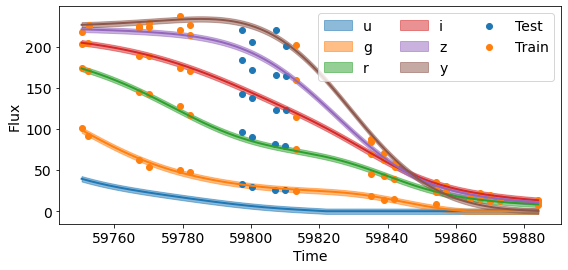

In [19]:
aug = fulu.SingleLayerNetAugmentation(passband2lam)

aug.fit(t_train, flux_train, flux_err_train, passband_train)
t_aug, flux_aug, flux_err_aug, passband_aug= aug.augmentation(t_min=t.min(), t_max=t.max(), n_obs=1000)

plot_light_curves_with_sigma(t_aug, flux_aug, flux_err_aug, passband_aug, title="")
plt.scatter(t_test, flux_test, label='Test')
plt.scatter(t_train, flux_train, label='Train')
plt.legend(loc='best', ncol=3, fontsize=14)

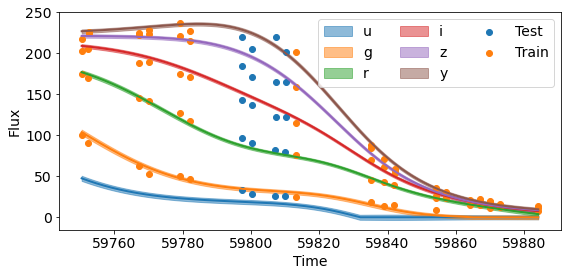

In [20]:
aug = fulu.BayesianNetAugmentation(passband2lam)

aug.fit(t_train, flux_train, flux_err_train, passband_train)
t_aug, flux_aug, flux_err_aug, passband_aug= aug.augmentation(t_min=t.min(), t_max=t.max(), n_obs=1000)

plot_light_curves_with_sigma(t_aug, flux_aug, flux_err_aug, passband_aug, title="")
plt.scatter(t_test, flux_test, label='Test')
plt.scatter(t_train, flux_train, label='Train')
plt.legend(loc='best', ncol=3, fontsize=14)

CPU times: user 26.9 s, sys: 593 ms, total: 27.5 s
Wall time: 27.3 s


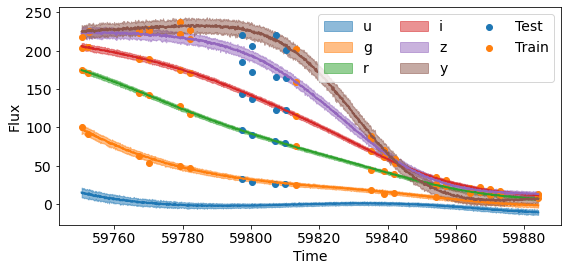

In [21]:
%%time
aug = fulu.NormalizingFlowAugmentation(passband2lam)

aug.fit(t_train, flux_train, flux_err_train, passband_train)
t_aug, flux_aug, flux_err_aug, passband_aug= aug.augmentation(t_min=t.min(), t_max=t.max(), n_obs=1000)

plot_light_curves_with_sigma(t_aug, flux_aug, flux_err_aug, passband_aug, title="")
plt.scatter(t_test, flux_test, label='Test')
plt.scatter(t_train, flux_train, label='Train')
plt.legend(loc='best', ncol=3, fontsize=14)